In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
# cut audio into frames
import os
import sys

import numpy as np
import pandas as pd
import yaml
import json
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

import torch
from torch import nn

import medleydb
from pitch_tracker import THESIS_2023_MODEL_PATH
from pitch_tracker.utils.constants import (F_MIN, HOP_LENGTH, N_FFT, N_MELS,
                                           PATCH_SIZE,
                                           PATCH_STEP,
                                           PATCH_TIME, SAMPLE_RATE,
                                           ANALYSIS_FRAME_SIZE, ANALYSIS_FRAME_TIME, WIN_LENGTH,
                                           N_CLASS, RANDOM_STATE)
from pitch_tracker.utils.audio import load_audio_mono
from pitch_tracker.utils.files import get_file_name, list_file_paths_in_dir, list_folder_paths_in_dir, list_all_file_paths_in_dir

# from pitch_tracker.utils import dataset, files
from pitch_tracker.utils.medleydb_melody import gen_label
from pitch_tracker.utils import dataset
from pitch_tracker.utils.dataset import AudioDataset
from pitch_tracker.ml.train_model import test
from pitch_tracker.ml.net import MPT2023


In [3]:
def plot_bars(dfs, figsize=(8, 8)):
    df = pd.concat(dfs, axis=1)
    fig, ax = plt.subplots(figsize=figsize)
    df.plot.bar(rot=45, ax=ax)
    for i in ax.containers:
        ax.bar_label(i)
    plt.show()

In [4]:
NOTEBOOK_DIR = os.getcwd()
MONO_PITCH_TRACKER_DIR = os.path.join(NOTEBOOK_DIR, '..')
MEDLEYDB_DIR = os.path.join(MONO_PITCH_TRACKER_DIR, 'medleydb/')

sys.path.append(MONO_PITCH_TRACKER_DIR)
sys.path.append(MEDLEYDB_DIR)

In [5]:
stft_hop_size = 512
analysis_frame_size = 5
n_mels = 88*2
onset_frame_time = stft_hop_size*analysis_frame_size/SAMPLE_RATE
pick_frame_time = PATCH_SIZE * onset_frame_time

DATASET_DIR = os.path.join(MONO_PITCH_TRACKER_DIR,f'content/pickled_database/{stft_hop_size}_{analysis_frame_size}_{n_mels}')
DATA_SPLIT_PATH = dataset.DATA_SPLIT_PATH


In [32]:
# This function takes in several arguments to control how the dataset is split. The by argument specifies the method used to split the data:
# If by is set to 'song_name': the data is randomized and split so that some samples from one song can be present in all three sets.
# If by is set to 'basaran2018CRNN': the data is split by artist according to a pre-defined split.
# If by is set to 'thesis': the data is split by genre with a test set identical to that of 'basaran2018CRNN' for comparison.
medleydb_train_df, medleydb_validation_df, medleydb_test_df = dataset.split_dataset_df(
    'thesis',
    pickled_data_dir=DATASET_DIR,
    train_ratio=0.8,
    random_state=24)
medleydb_test_set = medleydb_test_df['pickled_path']
medleydb_test_dataset = AudioDataset(medleydb_test_set)

Missing tracks: 0 []
Missing tracks: 0 []
train_set: 64
validation_set: 17
test_set: 27


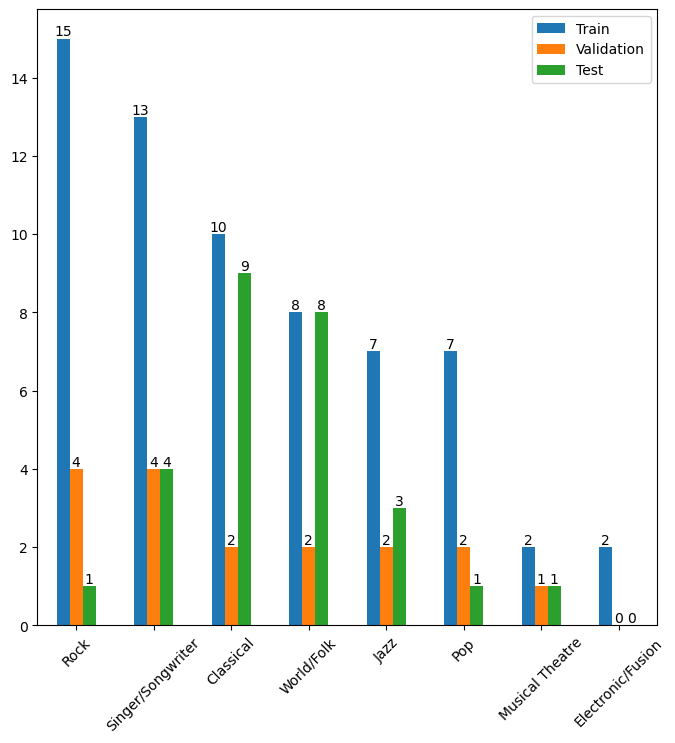

In [11]:
series = []
for df, name in zip([medleydb_train_df, medleydb_validation_df, medleydb_test_df], ['Train', 'Validation', 'Test']):
    s = df['genre'].value_counts()
    s.name = name
    series.append(s)
plot_bars(series) 

In [8]:
medleydb_test_samples = sum([len(list_all_file_paths_in_dir(dir_path)) for dir_path in medleydb_test_df['pickled_path']])

print('Number of patches:')
print(f'test: {medleydb_test_samples}')

Number of patches:
test: 945


In [14]:
ADC2004_DATASET_PATH = f'{MONO_PITCH_TRACKER_DIR}/content/pickled_database/ADC2004/{stft_hop_size}_{analysis_frame_size}_{n_mels}/'
MIREX05_DATASET_PATH = f'{MONO_PITCH_TRACKER_DIR}/content/pickled_database/MIREX05/{stft_hop_size}_{analysis_frame_size}_{n_mels}/'
ADC2004_DATASET_PATH,MIREX05_DATASET_PATH

('/Users/tien.d/workspace/GITHUB/mono_pitch_tracker/notebooks/../content/pickled_database/ADC2004/512_5_176/',
 '/Users/tien.d/workspace/GITHUB/mono_pitch_tracker/notebooks/../content/pickled_database/MIREX05/512_5_176/')

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_available() \
    else "cpu"

In [30]:
model = MPT2023()
model.load_state_dict(torch.load(THESIS_2023_MODEL_PATH, map_location=DEVICE))
model=model.to(DEVICE)

/Users/tien.d/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/tien.d/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [31]:
loss_fn = nn.CrossEntropyLoss().to(DEVICE)


test_dataloader = DataLoader(
    medleydb_test_dataset,
    batch_size=4,
    shuffle=False
)
test(model, test_dataloader, loss_fn, DEVICE)

/Users/tien.d/workspace/GITHUB/mono_pitch_tracker/pitch_tracker/ml/train_model.py:154: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  n_correct += torch.nonzero(pos_neg_arr).numel()


Test Error: 
 Accuracy: 26.7%, Avg loss:      nan 
Overall Accuracy: 0.2671
Voicing Recall: 0.0055, Voicing False Alarm: 0.0223,
Raw Pitch Accuracy: 0.0000, Raw Chroma Accuracy: 0.0005,



(nan, 0.2671403376165281)